In [1]:
%matplotlib inline
from parcels import Field, FieldSet, ParticleSet,Variable, JITParticle, ErrorCode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc, animation
import xarray as xr

from IPython.display import Image
rc('animation', html='html5')

fatal: not a git repository (or any of the parent directories): .git


In [2]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure"""
    print(f'Particle {particle.id} lost !! [{particle.time}, {particle.depth}, {particle.lat}, {particle.lon}]')
    particle.delete()

In [3]:
#This vertical profile was pulled from erddap
Dat = pd.read_csv('ubcSSg3DwGridFields1hV19-05_9244_b1de_6bbd.csv')
depth=np.array(Dat.depth)[1:].astype('float32')
Kz_col=np.array(Dat.vert_eddy_diff)[1:].astype('float32')

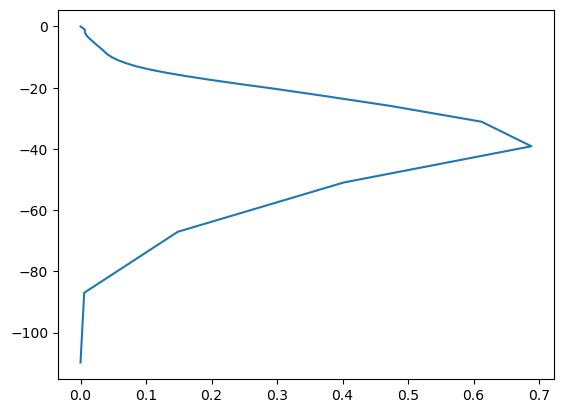

In [11]:
plt.plot(Kz_col,-depth)

In [7]:
#Here you can define as many particle variables as you want specifying the initial values. In this case, I use the variable to set a constant.
class MPParticle(JITParticle):
    Kzf = Variable('Kzf', initial =  1.0) 
    bath = Variable('bath', initial= depth[-1])

In [8]:
def tu_mix(particle,fieldset,time):
    bath= particle.bath #109.73707
    if particle.depth+0.5 > bath: #Only calculate gradient of diffusion for particles deeper than 0.6 otherwise OP will check for particles outside the domain and remove it.
        Kzdz = 2*(fieldset.Kz[time,particle.depth,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth-0.5,particle.lat, particle.lon]) #forward difference 
    else: 
        Kzdz = 2*(fieldset.Kz[time,particle.depth+0.5,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth,particle.lat, particle.lon]) #forward difference 
    dgrad = Kzdz * particle.dt * particle.Kzf
    if particle.depth+0.5*dgrad > 0:
        kk = fieldset.Kz[time,particle.depth+0.5*dgrad,particle.lat, particle.lon] #Vertical diffusivity SSC  #
    else:
        kk = fieldset.Kz[time, 0,particle.lat, particle.lon] #Vertical diffusivity SSC  #
    Kx = 1.5
    Rr = ParcelsRandom.uniform(-1, 1)
    Rr2 = ParcelsRandom.uniform(-1, 1)
    d_random = sqrt(3*2*kk*particle.dt) * Rr
    d_randomx = sqrt(3*2*Kx*particle.dt) * Rr2
    Dlayerz = 0.5*sqrt(kk * particle.dt) #1m mixing layer
    Dlayerx = 0.5*sqrt(Kx * particle.dt)
    if particle.lon + d_randomx < 0:
        particle.lon = Dlayerx * ParcelsRandom.uniform(0, 1)
    elif particle.lon + d_randomx > 2e3:
        particle.lon = 2e3 - Dlayerx * ParcelsRandom.uniform(0, 1)
    else: 
        particle.lon=particle.lon + d_randomx
    if d_random + dgrad +particle.depth > bath: #randomly in the water column
        particle.depth = bath - Dlayerz * ParcelsRandom.uniform(0, 1)
    elif d_random +particle.depth +dgrad < 0:
            particle.depth = Dlayerz * ParcelsRandom.uniform(0, 1) #Well mixed boundary layer
    else:
        particle.depth += d_random + dgrad 

In [6]:
dim = 100
dep = len(depth)
lon = np.linspace(0., 2e3, dim, dtype=np.float32)
dep2= np.linspace(0., depth[-1], dim, dtype=np.float32)
#lon_g, depth_g = np.meshgrid(lon,dep2)
U = Field('U', np.zeros((dep, dim), dtype=np.float32), lon=lon, depth=depth)
V = Field('V', np.zeros((dep, dim), dtype=np.float32), lon=lon, depth=depth)
Kz_data = np.zeros((dep, dim), dtype=np.float32)
for i in range(dim):
    Kz_data[:,i]=Kz_col
Kz = Field('Kz', Kz_data, grid=U.grid)

In [7]:
fieldset = FieldSet(U,V)
fieldset.add_field(Kz)

In [8]:
lon_g = np.random.uniform(low=lon[0], high=lon[-1], size=(10*dim,))
depth_g = np.random.uniform(low=depth[0], high=depth[-1], size=(10*dim,))
lat_g = np.zeros(10*dim,)

In [9]:
def run_turb_test(lon_g,depth_g):
    pset = ParticleSet(fieldset, pclass=MPParticle, lon=lon_g, depth=depth_g,lat = lat_g)
    pset2 = ParticleSet(fieldset, pclass=MPParticle2, lon=lon_g, depth=depth_g,lat = lat_g)
    output_file = pset.ParticleFile(name='/home/jvalenti/MOAD/results/Outputmix.zarr', outputdt=50)
    output_file2 = pset2.ParticleFile(name='/home/jvalenti/MOAD/results/Outputmix2.zarr', outputdt=50)
    KE=tu_mix
    pset.execute(KE , runtime=5e3, dt=5, output_file=output_file,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
    pset2.execute(KE , runtime=5e3, dt=5, output_file=output_file2,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

In [10]:
run_turb_test(lon_g,depth_g)

INFO: Compiled ArrayMPParticletu_mix ==> /tmp/parcels-2894/lib489ac8d69f3d38bcb3141a928df80879_0.so
INFO: Output files are stored in /home/jvalenti/MOAD/results/Outputmix.zarr.
100%|██████████| 5000.0/5000.0 [00:02<00:00, 2283.95it/s] 
INFO: Compiled ArrayMPParticle2tu_mix ==> /tmp/parcels-2894/lib75b2cf217b70503cca88537ea17b6039_0.so
INFO: Output files are stored in /home/jvalenti/MOAD/results/Outputmix2.zarr.
100%|██████████| 5000.0/5000.0 [00:01<00:00, 2838.26it/s] 


In [11]:
dat = xr.load_dataset('/home/jvalenti/MOAD/results/Outputmix.zarr')
dat2 = xr.load_dataset('/home/jvalenti/MOAD/results/Outputmix2.zarr')

/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [12]:
def anim2(file1,file2,fps=1):  
    box=([0,2e3,2e3,0,0],[0,0,depth[-1],depth[-1],0])
    fig,axs=plt.subplots(1,4,figsize=(15,10))
    axs[0].scatter(dat.lon[:,0],dat.z[:,0],s=5)
    #ax2 = axs[2].twiny()
    #ax2.plot(Kz_col,depth,c='r')
    axs[3].plot(Kz_col,depth,c='r')
    axs[3].set_title('Vertical profile $K_z$ [$m^2/s$]')
    axs[3].invert_yaxis()
    axs[0].plot(box[0],box[1],c='grey',linewidth=3)
    axs[1].plot(box[0],box[1],c='grey',linewidth=3)
    axs[2].plot(box[0],box[1],c='grey',linewidth=3)
    axs[0].invert_yaxis()
    axs[0].set_title('Initial condition (t: 0s)')
    axs[1].invert_yaxis()
    axs[1].set_title("With $K_z$' correction (t: 5*$10^3$s)")
    axs[2].invert_yaxis()
    axs[2].set_title("Without $K_z$' correction (t: 5*$10^3$s)")
    axs[0].set_ylabel('Depth (m)')

    def update(frame):           
        global ss        
        for scat in ss:              
            scat.remove()            
        ss =[]                    
        ss.append(axs[1].scatter(file1.lon[:,frame],file1.z[:,frame],s=5,c ='tab:blue'))         
        ss.append(axs[2].scatter(file2.lon[:,frame],file2.z[:,frame],s=5,c ='tab:blue'))                      
        print(f'{frame/len(file1):.2f}% completed')           
        return ss
    return animation.FuncAnimation(fig, update, frames=np.arange(0,100,fps))

0.00% completed
0.00% completed
2.00% completed
4.00% completed
6.00% completed
8.00% completed
10.00% completed
12.00% completed
14.00% completed
16.00% completed
18.00% completed
0.00% completed


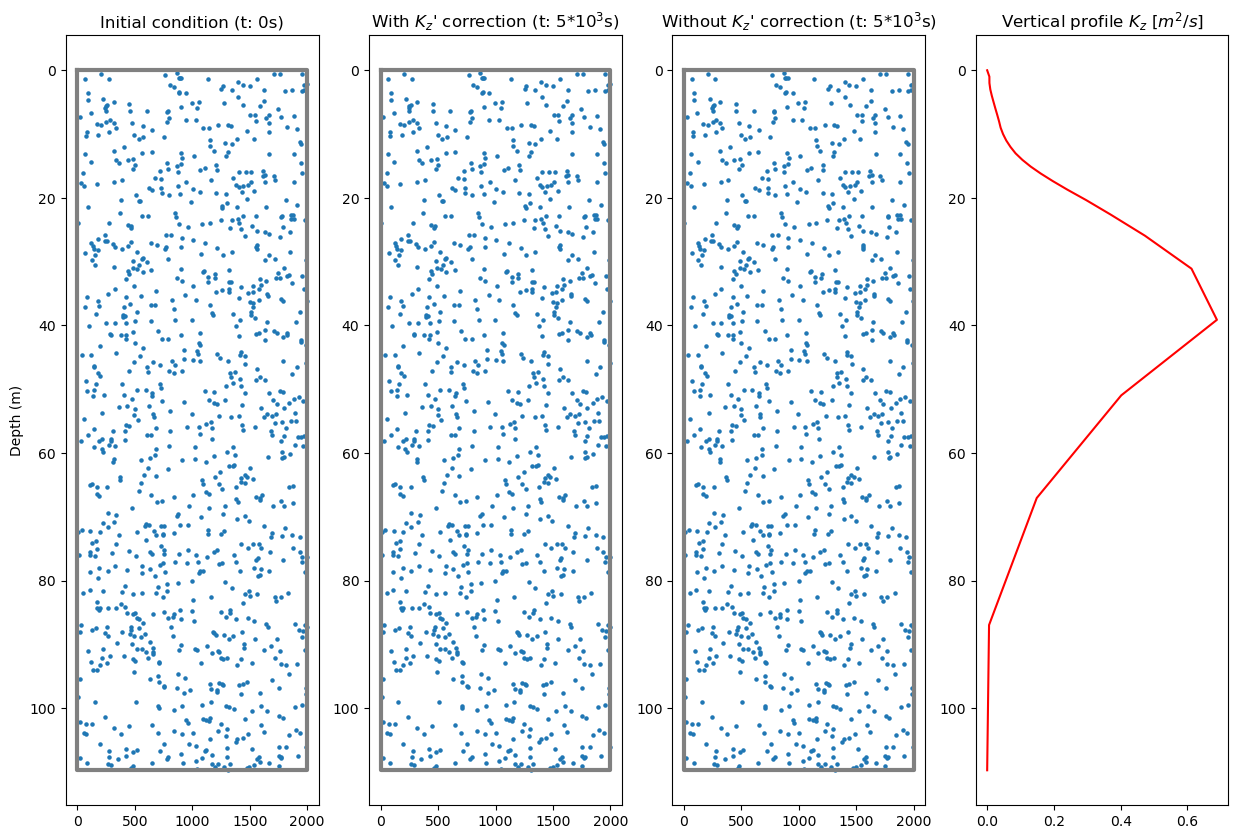

In [13]:
ss =[]
ani = anim2(dat,dat2,fps=10)
f = r"/home/jvalenti/MOAD/animations/mix.gif" 
FFwriter = animation.FFMpegWriter()
ani.save(f, writer = FFwriter)

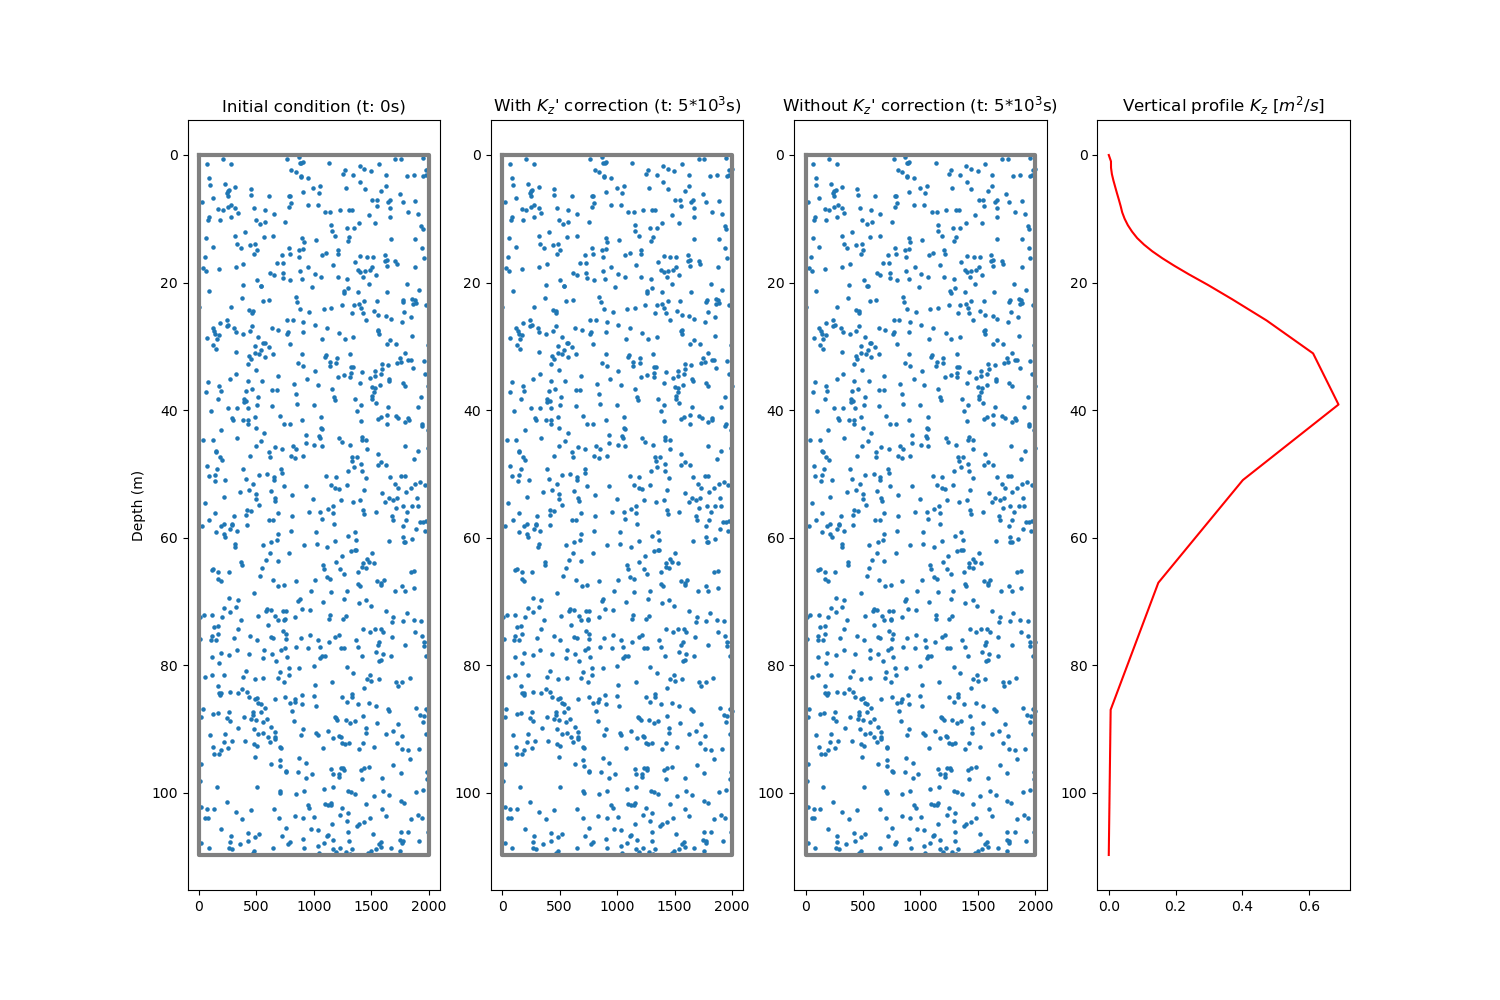

In [14]:
with open(f,'rb') as anim:
     display(Image(anim.read()))

Text(0, 0.5, 'Depth (m)')

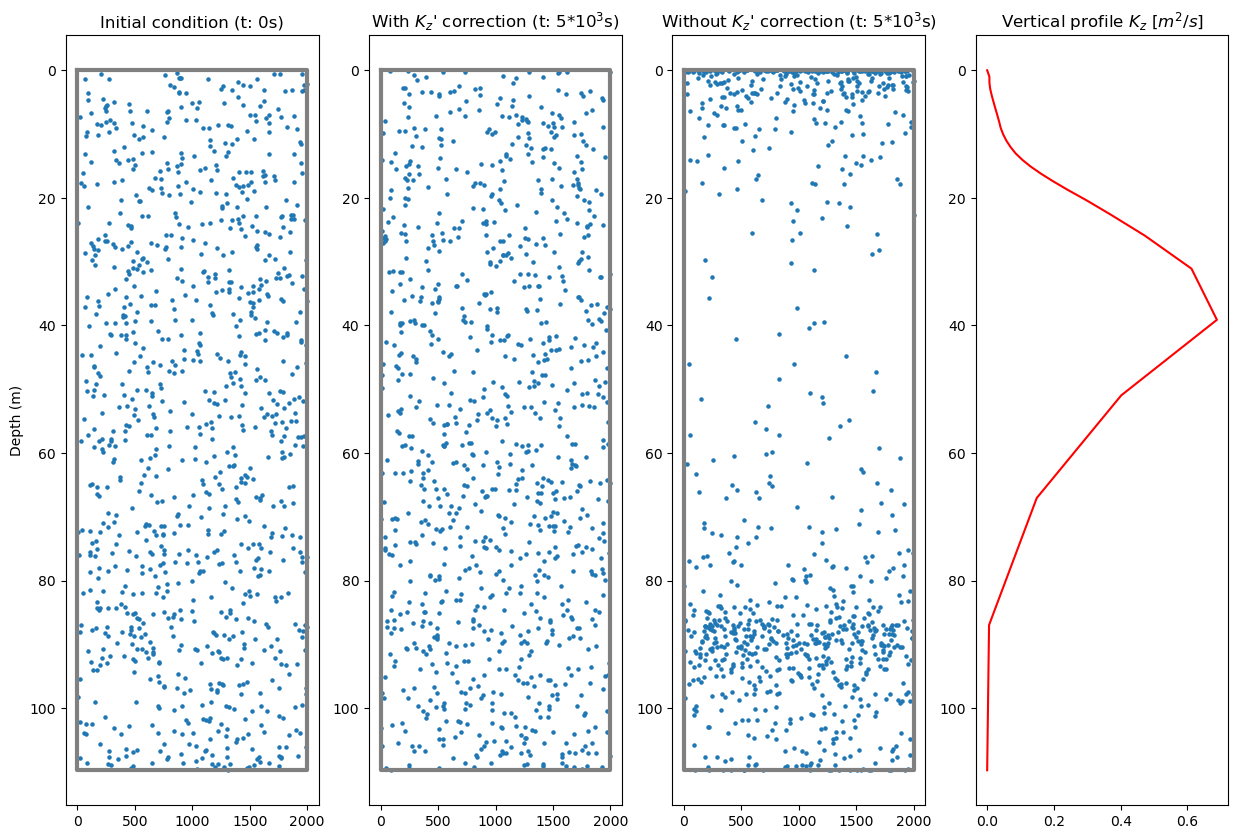

In [15]:
box=([0,2e3,2e3,0,0],[0,0,depth[-1],depth[-1],0])
fig,axs=plt.subplots(1,4,figsize=(15,10))
axs[0].scatter(dat.lon[:,0],dat.z[:,0],s=5)
#ax2 = axs[2].twiny()
#ax2.plot(Kz_col,depth,c='r')
axs[3].plot(Kz_col,depth,c='r')
axs[3].set_title('Vertical profile $K_z$ [$m^2/s$]')
axs[3].invert_yaxis()
axs[0].plot(box[0],box[1],c='grey',linewidth=3)
axs[1].plot(box[0],box[1],c='grey',linewidth=3)
axs[2].plot(box[0],box[1],c='grey',linewidth=3)
axs[0].invert_yaxis()
axs[0].set_title('Initial condition (t: 0s)')
axs[1].scatter(dat.lon[:,-1],dat.z[:,-1],s=5)
axs[1].invert_yaxis()
axs[1].set_title("With $K_z$' correction (t: 5*$10^3$s)")
axs[2].scatter(dat2.lon[:,-1],dat2.z[:,-1],s=5)
axs[2].invert_yaxis()
axs[2].set_title("Without $K_z$' correction (t: 5*$10^3$s)")
axs[0].set_ylabel('Depth (m)')

In [47]:
def entropy(data, bins=100):
    """
        Calculate entropy of multiple varibles (discrete and continous).
        X is a 2d-array, each column is a variable.
    """
    hist = np.histogramdd(data, bins=bins)[0]
    prob = hist/len(data)
    prob[prob == 0] = 1
    log_prob = np.log2(prob)
    

    return -np.sum(np.multiply(prob, log_prob))

In [48]:
def no_nan(x,y):
    no_nan=[]
    no_nan1=[]
    for i,xi in enumerate(x):
        if np.isnan(xi) == False:
            no_nan.append(xi) 
            no_nan1.append(y[i]) 
    return no_nan,no_nan1

d0,l0=no_nan(dat2.lat[:,0],dat2.lon[:,0])
e0=entropy([d0,l0])

In [49]:
import sys, os

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

In [50]:
def run_n_test(n):
    e1,e2=[],[]
    for i in range(n):
        lon_g = np.random.uniform(low=lon[0], high=lon[-1], size=(10*dim,))
        depth_g = np.random.uniform(low=depth[0], high=depth[-1], size=(10*dim,))
        run_turb_test(lon_g,depth_g)
        dat = xr.load_dataset('/home/jvalenti/MOAD/results/Outputmix.zarr')
        dat2 = xr.load_dataset('/home/jvalenti/MOAD/results/Outputmix2.zarr')
        d0,l0=no_nan(dat.z[:,0],dat.lon[:,0])
        e0=entropy([d0,l0])
        d2,l2=no_nan(dat2.z[:,-1],dat2.lon[:,-1])
        e2.append(entropy([d2,l2])-e0)
        d1,l1=no_nan(dat.z[:,-1],dat.lon[:,-1])
        e1.append(entropy([d1,l1])-e0)
    m1=np.mean(e1)
    sd1=np.std(e1)/np.sqrt(n)
    m2=np.mean(e2)
    sd2=np.std(e2)/np.sqrt(n)
    return m1,sd1,m2,sd2

In [54]:
blockPrint()
m1,sd1,m2,sd2=run_n_test(10)
enablePrint()

CTEs = [m1, m2]
error = [sd1, sd2]

INFO: Compiled ArrayMPParticletu_mix ==> /tmp/parcels-2894/lib60f255d77aab1fb3cbae2c199e53318b_0.so
INFO: Output files are stored in /home/jvalenti/MOAD/results/Outputmix.zarr.
100%|██████████| 5000.0/5000.0 [00:01<00:00, 2546.99it/s] 
INFO: Compiled ArrayMPParticle2tu_mix ==> /tmp/parcels-2894/libc545bfddd0a07c0f9c19c6c11a73cc70_0.so
INFO: Output files are stored in /home/jvalenti/MOAD/results/Outputmix2.zarr.
100%|██████████| 5000.0/5000.0 [00:02<00:00, 2305.02it/s] 
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: Runt

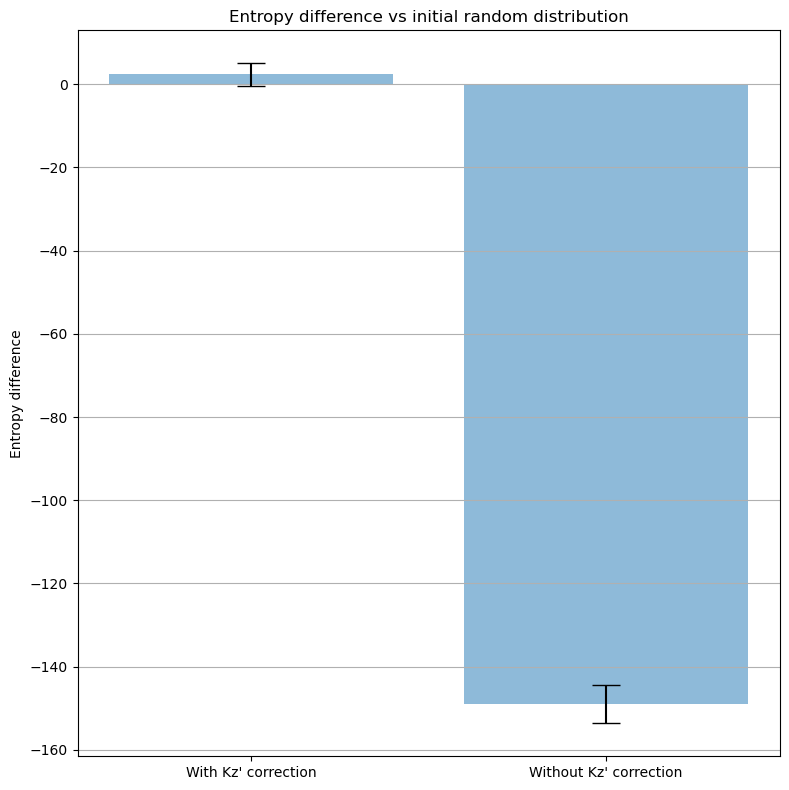

In [55]:
# Build the plot
x_pos=np.arange(2)
fig, ax = plt.subplots(figsize=(8,8))
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Entropy difference')
ax.set_xticks(x_pos)
ax.set_xticklabels(["With Kz' correction","Without Kz' correction"])
ax.set_title('Entropy difference vs initial random distribution')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()

In [53]:
d1,l1=no_nan(dat.lat[:,-1],dat.lon[:,-1])
entropy([d1,l1])-e0

-0.8267969204994188